# 1- Learning 🤗  - Out-of-the-box BERT [LB: 0.577]

Hi, and welcome! This is the first kernel of the series `Learning 🤗`, a personal project I'm currently working on. I am an experienced data scientist diving into the hugging face transformers library and this series or kernels is a "working diary", as I do it. The approach I'm taking is the following: 
1. Explore various out-of-the-box models, without digging into their technical details. 
2. After that, I'll start going over the best ranked public kernels, understand their ideas, and reproduce them by myself. 

You are invited to follow me in this journey. In this short kernel (~80 lines) we fine-tune an out-of-the-box cased BERT, with just the minimal set up required for it to run in this competition, obtaining a leaderboard score of `0.577`. 

This is an ongoing project, so expect more notebooks to be added to the series soon. Actually, we are currently working on the following ones:

1. [Learning 🤗  - Out-of-the-box BERT [LB: 0.577]](https://www.kaggle.com/julian3833/1-learning-out-of-the-box-bert-lb-0-577) (this notebook)
2. [Learning 🤗 - Out-of-the-box RoBERTa [LB: 0.53]](https://www.kaggle.com/julian3833/2-learning-out-of-the-box-roberta-lb-0-53)
3. [Learning 🤗 - Out-of-the-box Electra [LB: 0.58]](https://www.kaggle.com/julian3833/3-learning-out-of-the-box-electra-lb/) 
4. _Learning 🤗 - Minimal fine tuning (WIP)_
5. _Learning 🤗 - Preprocessing (WIP)_
6. _Learning 🤗 - Reviewing public kernels (WIP)_
7. _Learning 🤗 - Intra-domain pre training RoBERTa (WIP)_



## Using the [`transformers`](https://huggingface.co/transformers/) library

We are using a very high-level API of the library after following this quick guide article, which we recommend to read:
[Fine-tuning a pretrained model](https://huggingface.co/transformers/training.html)

We use only 4 objects from the library: `Trainer`, `TrainingArguments`, `AutoModelForSequenceClassification`, `AutoTokenizer`. And, actually, the full list of imports is quite small as you can see below:

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments, AutoTokenizer,\
                         AutoModelForSequenceClassification




## Note about pretrained models

This competition has two requirements:
* Submissions should be done from Kaggle notebooks
* Internet should be turned off

Since the transformers library uses Internet to download the pretrained models from its model hub, we must do some changes to the simplest work flow proposed in the "quick guide". The Kaggle community has overcome this situation adding pretrained models as "Datasets".

To use pretrained models, you should search for them in the dataset tab and find the one you want to use.

You can check the details of the "dataset" we are using [here](https://www.kaggle.com/xhlulu/huggingface-bert):

To add any of these pretrained models, go to the "Add Data" button in the top right corner of the kernel editor:

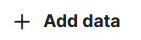

Go to the search:

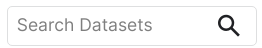

And press the "Add" button on the one you want:

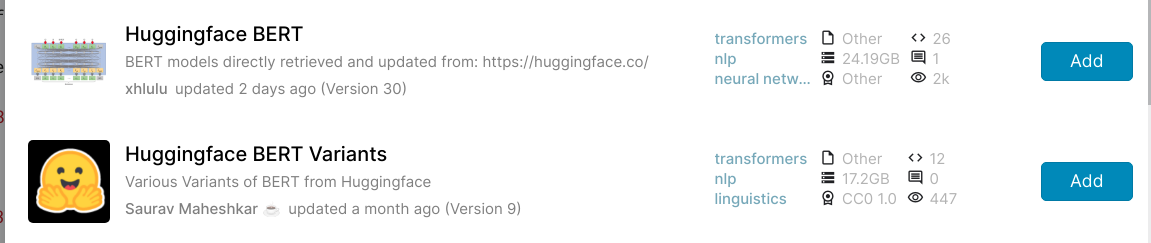

The files will be located in the path `../input/` in remote file system.

In this case, the reference is:
```python
MODEL_NAME = "../input/huggingface-bert/bert-base-cased"
```


## The code

We have split the code in various simple functions to separates the wheat from the chaff and focus on the parts that are new to us.

Documentation about the `Trainer` can be found [here](https://huggingface.co/transformers/main_classes/trainer.html) and about the `TrainerArguments` [here](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments).

In [ ]:
# This is simply two pandas.read_csv calls
def load_dfs():
    """Loads train and test CSVs and keeps only relevant columns
    
    Returns two DataFrames
        Train with columns ['text', 'label'] 
        Test with columns ['id, 'text']
    """
    train_csv = '../input/commonlitreadabilityprize/train.csv'
    test_csv = '../input/commonlitreadabilityprize/test.csv'
    df_train = pd.read_csv(train_csv)[["excerpt", "target"]]\
                 .rename(columns={"target": "label", "excerpt": "text"})
    df_test = pd.read_csv(test_csv)[["id", "excerpt"]]\
                .rename(columns={ "excerpt": "text"})
    return df_train, df_test

# Simple RMSE calculation
def rmse(y_true, y_pred):
    return np.sqrt(((y_true - y_pred) ** 2).mean().item())
    
    
# Compute metrics is an argument of the Trainer
def compute_metrics(pred_results):
    """For computing RMSE inside the training loop"""
    y_pred = pred_results.predictions.squeeze()
    y_true = pred_results.label_ids
    return {"rmse": rmse(y_true, y_pred)}


def submit(trainer, ds_test):
    """Generates predictions with the Trainer for the test dataset and writes them to disk"""
    sample_sub_csv = '../input/commonlitreadabilityprize/sample_submission.csv'
    pred_csv = '/kaggle/working/submission.csv'

    pred_results = trainer.predict(ds_test)
    y_pred = pred_results.predictions.squeeze()
    df_res = pd.read_csv(sample_sub_csv)
    df_res['target'] = y_pred.tolist()
    df_res.to_csv(pred_csv, index=False)


def tokenize(tokenizer, df_train, df_val, df_test):
    """ Applies the tokenizer to the text columns of the 3 dataframes """
    # We apply padding="max_length" and truncation=True because 
    # the quick guide showed it this way
    # The max_length=512 was more difficult: the pretrained models 
    # from the modelhub ("bert-base-cased") don't require this parameter
    # We had to find it by hand for BERT and set it here
    train_tokenized = tokenizer(df_train['text'].tolist(), padding="max_length", truncation=True, max_length=512)
    val_tokenized = tokenizer(df_val['text'].tolist(), padding="max_length", truncation=True, max_length=512)
    test_tokenized = tokenizer(df_test['text'].tolist(), padding="max_length", truncation=True, max_length=512)
    
    train_tokenized['label'] = df_train['label'].tolist()
    val_tokenized['label'] = df_val['label'].tolist()
    
    # This is currently the only way I found to reverse a dictionary of lists 
    # into a list of dictionaries
    # Probably something more informed will achieve the same with less code and goes and forths
    ds_train = [dict(zip(train_tokenized,t)) for t in zip(*train_tokenized.values())]
    ds_val = [dict(zip(val_tokenized,t)) for t in zip(*val_tokenized.values())]
    ds_test = [dict(zip(test_tokenized,t)) for t in zip(*test_tokenized.values())]
    return ds_train, ds_val, ds_test

In [ ]:
# Load the tokenizer and the model

MODEL_NAME = "../input/huggingface-bert/bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1)


# Create tokenized train, validation and test (aka prediction) datasets
df_base, df_test = load_dfs()
df_train, df_val = train_test_split(df_base, test_size=0.066)
ds_train, ds_val, ds_test = tokenize(tokenizer, df_train, df_val, df_test)

# Prepare the trainer
# The report_to="none" was required to disable something called "wandb"
# Later we will research what is wandb and set it back
# Set epochs to 3
args = TrainingArguments("/kaggle/working/model/", num_train_epochs=3, 
                         evaluation_strategy="steps", eval_steps=100, report_to="none")

trainer = Trainer(model=model, args=args, train_dataset=ds_train, eval_dataset=ds_val, 
                  compute_metrics=compute_metrics)

# Train the model
trainer.train()

# Create the submission
submit(trainer, ds_test)

### 🤗🤗 Thanks for reading this notebook! Remember to upvote if you found it useful, and stay tuned for the next deliveries! 🤗🤗